In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import rdkit
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv("tg.csv")
df.shape

(7174, 2)

In [3]:
# Define function to calculate relevant descriptors from SMILES
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Important descriptors
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),  # Molecular weight (affects free volume)
            'LogP': Descriptors.MolLogP(mol),  # Hydrophobicity (affects Tg)
            'TPSA': Descriptors.TPSA(mol),  # Polarity (affects intermolecular interactions)
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),  # Molecular flexibility
            'NumAromaticRings': Descriptors.NumAromaticRings(mol),  # Rigidity
            'Chi0': Descriptors.Chi0(mol),
            'LabuteASA': Descriptors.LabuteASA(mol),
        }
        return descriptors
    else:
        return None  # Handle invalid SMILES cases

In [4]:
def calculate_harary_index(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol or mol.GetNumAtoms() < 2:
        return np.nan  # Return NaN for invalid or single-atom molecules

    # Convert RDKit molecule to NetworkX graph
    G = nx.Graph([(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()])

    # Compute shortest path lengths
    dist_dict = dict(nx.all_pairs_shortest_path_length(G))

    # Compute Harary Index
    harary_index = sum(1 / dist_dict[u][v] for u in dist_dict for v in dist_dict[u] if u < v)

    return harary_index

In [5]:
# Generate selected descriptors for each molecule
descriptors = df['smiles'].apply(calculate_descriptors)
descriptor_df = pd.DataFrame(descriptors.tolist())
descriptor_df['HararyIndex'] = df['smiles'].apply(calculate_harary_index)

# Concatenate descriptors with the target column 'tg'
final_df = pd.concat([descriptor_df, df['tg']], axis=1)

In [6]:
final_df.head()

,MolWt,LogP,TPSA,NumRotatableBonds,NumAromaticRings,Chi0,LabuteASA,HararyIndex,tg
0,14.027,0.4608,0.0,0,0,2.707107,8.739251,2.500000,-54.0
1,42.081,1.3117,0.0,1,0,4.284457,21.469135,6.666667,-3.0
2,56.108,1.7018,0.0,2,0,4.991564,27.834077,9.083333,-24.1
3,70.135,2.0919,0.0,3,0,5.698671,34.199019,11.616667,-37.0
4,70.135,1.9478,0.0,2,0,5.861807,34.199019,12.000000,60.0


In [7]:
# Applying Isolation Forest
X = final_df.drop(columns=['tg'])  

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=60)  # contamination is the expected proportion of outliers
outliers = iso_forest.fit_predict(X)

# Add the outlier prediction results to the DataFrame (1 for inliers, -1 for outliers)
final_df['Outlier'] = outliers

In [8]:
# Create a new column to indicate outliers in the original df DataFrame
df['Outlier'] = outliers

# Filter the original df DataFrame for inliers (Outlier == 1)
inliers_df = df[df['Outlier'] == 1]

# Filter the original df DataFrame for outliers (Outlier == -1)
outliers_df = df[df['Outlier'] == -1]

In [9]:
df.head()

,smiles,tg,Outlier
0,*C*,-54.0,-1
1,*CC(*)C,-3.0,1
2,*CC(*)CC,-24.1,1
3,*CC(*)CCC,-37.0,1
4,*CC(*)C(C)C,60.0,1


In [10]:
# Make inliers (1) and outliers (-1) for Scatter plot
inliers = final_df[final_df['Outlier'] == 1]
outliers = final_df[final_df['Outlier'] == -1]

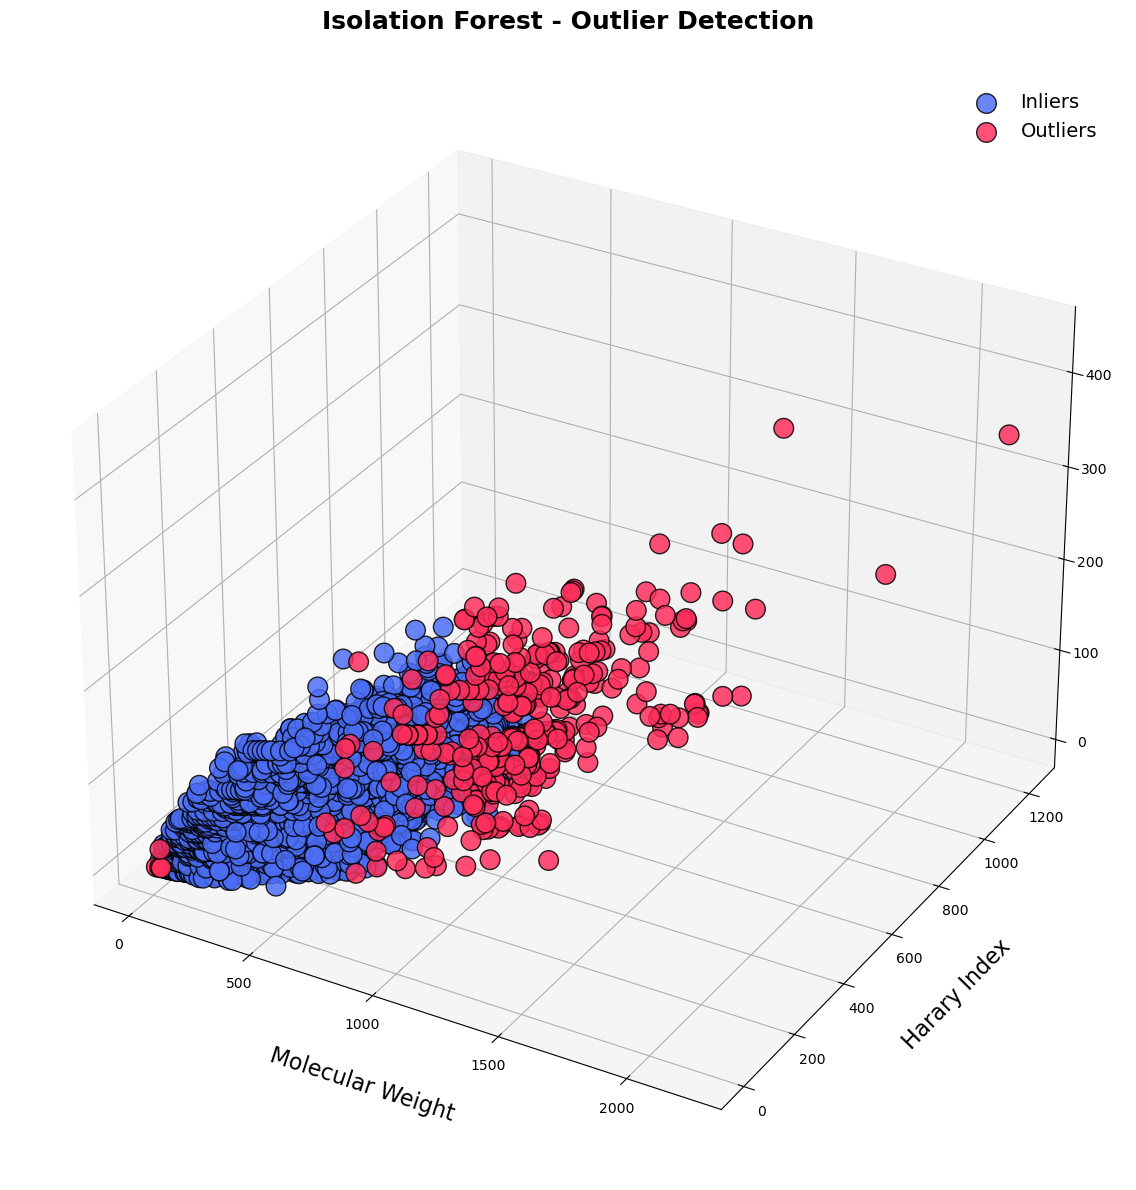

In [11]:
# Create figure and axes for 3D plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Professional colors for inliers and outliers
inlier_color = '#4c6ef5'  # Soft blue
outlier_color = '#ff2f5c'  # Muted red

# Plot the inliers
ax.scatter(inliers['MolWt'], inliers['HararyIndex'], inliers['TPSA'], 
           c=inlier_color, edgecolors='black', label='Inliers', 
           s=200, alpha=0.84, marker='o')

# Plot the outliers
ax.scatter(outliers['MolWt'], outliers['HararyIndex'], outliers['TPSA'], 
           c=outlier_color, edgecolors='black', label='Outliers', 
           s=200, alpha=0.84, marker='o')

# Label the axes and set title with improved styling
ax.set_xlabel('Molecular Weight', fontsize=16, labelpad=20)
ax.set_ylabel('Harary Index', fontsize=16, labelpad=20)
ax.set_title('Isolation Forest - Outlier Detection', fontsize=18, fontweight='bold', color='Black', pad=25)

# Add grid lines
ax.grid(True, linestyle='-', color='gray', alpha=0.8)

# Customize the legend with better positioning
ax.legend(loc='upper right', fontsize=14, frameon=False, borderpad=1)

# Set background colors for clarity
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Remove spines or set to dark color
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# Remove any empty space around the plot
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
inliers_df

,smiles,tg,Outlier
1,*CC(*)C,-3.0,1
2,*CC(*)CC,-24.1,1
3,*CC(*)CCC,-37.0,1
4,*CC(*)C(C)C,60.0,1
5,*CC(*)CCCC,-50.0,1
...,...,...,...
7169,*CC(*)(F)C(=O)OCCC,62.0,1
7170,*CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F,152.0,1
7171,*CC(F)(F)C1(F)CC(CC(O)(C(F)(F)F)C(F)(F)F)CC1*,98.0,1
7172,*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F)C(F)(F)F)CC1*,118.0,1


In [13]:
# saving df
inliers_df.to_csv('tg_inliers.csv', index=False)